In [1]:
import requests
import urllib
from datetime import datetime
import pandas as pd
from IPython.display import display
import json


LEAUGE_TYPE = "NBA"

from OddsAPI import API
api = API()

markets = []
with open("Settings.json") as f:
    markets = json.load(f)[LEAUGE_TYPE]["markets"]

In [2]:
def process_master(data):
    df = pd.DataFrame.from_dict(data['market']['outcomes'])
    df = df[~df['description'].str.contains("Alt", case=False)]

    
    if data['bookie_key'] == "pinnacle":
        df = df.copy()
        df.dropna()
        df = df[['handicap', 'odds', 'participant_name', 'name']]
        return df
    # elif data['bookie_key'] == "fanduel":
    #     df = df.copy()
    #     df = df[['handicap', 'odds', 'name']]
    #     print(df)
    #     df[['participant_name', 'name']] = df['name'].str.rsplit(' ', 1, expand=True)

    #     df = df.dropna()
    #     return df
    elif data['bookie_key'] == "draftkings":
        df = df.copy()
        df = df[['handicap', 'odds', 'name']]

        df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
        df['participant_name'] = df['participant_name'].str.strip()

        df.dropna()
    
        return df
    elif data['bookie_key'] == "betrivers":
        df = df.copy()
        df = df[['handicap', 'odds', 'name']]

        df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
        df['participant_name'] = df['participant_name'].str.strip()

        df.dropna()

        return df

In [3]:
## pivot: converts a dataframe that contains two seperate rows for each player (one for over, one for under) to have one row for each player
def pivot(df):
    df = df.copy()
    pivot_df = pd.pivot_table(df, values='odds', index=['handicap', 'participant_name'], columns='name').reset_index()
    pivot_df.columns = ['line', 'participant_name', 'over_odds', 'under_odds']

    return pivot_df

## calculate odds
## adapted from Ammar Sulmanjee
def calculate_odds(x, y=None):
    if not y:
        if x>= 0: return 1 + x/100
        return 1 + 100/abs(x)

    imp_prob1 = (1 / calculate_odds(x)) * 100
    imp_prob2 = (1 / calculate_odds(y)) * 100

    total_implied_prob = round(imp_prob1 + imp_prob2, 4)
    fair_prob1 = round(imp_prob1 / total_implied_prob * 100, 2)
    fair_prob2 = round(imp_prob2 / total_implied_prob * 100, 2)

    index = "over" if fair_prob1 > fair_prob2 else "under"

    return {"type": index, "ev": max(fair_prob1, fair_prob2) - 50}

In [4]:
bets = pd.DataFrame(columns = ['participant_name', 'ev', 'market', 'line'])
bet_data = pd.DataFrame(columns=['book', 'participant_name', 'market', 'line'])
raw_bet_data = pd.DataFrame() ### IMPLEMENT


## get games
games = api.get_nba_games()
games = [i['game_id'] for i in games['games']]

https://api.prop-odds.com/beta/games/nba?date=2024-01-29&tz=America%2FNew_York&api_key=oQK8ATTYc0ug8atzBGvgLKPOKWCaVSMOpbnWPmnE8E


In [10]:
### Pull Underdog Lines
# result: ud (DataFrame) contains underdog lines + names, games_to_check (dictionary) contains each game, with its corresponding markets to check

ud = pd.DataFrame.from_dict(api.get_fantasy_lines("NBA")['fantasy_books'])

ud = ud[ud['bookie_key'] == "underdog"]
ud = pd.DataFrame.from_dict(list(ud["markets"])[0])
ud.columns = ['markets', 'lines']

df = pd.DataFrame(columns=['participant_name', 'line', 'game_id', 'market'])

lines = list(ud['lines'])
markets = list(ud['markets'])

for x, line in enumerate(lines):
    for prop in line:
        temp = pd.DataFrame()

        temp['participant_name'] = [prop['participant_name']]
        temp['line'] = [prop['line']]
        temp['game_id'] = [prop['game_id']]
        temp['market'] = markets[x]

        df = pd.concat([df, temp], axis=0)

df=df.reset_index()
df = df.drop(columns=['index'])
df = df.sort_values(by=['game_id'])


ud = df[['participant_name', 'line']]
ud.columns = [ud.columns[0], 'handicap']

result_df = df.groupby('game_id')['market'].agg(list).reset_index()
games_to_check = dict(zip(result_df['game_id'], result_df['market']))

In [12]:
for game in games_to_check:
    for market in games_to_check[game]:

        # get sportsbook odds
        bookies_data = api.get_most_recent_odds(game, market)
        books = []
        book_order = []
        for bookie in bookies_data['sportsbooks']:
            if bookie['bookie_key'] == "pinnacle" or bookie['bookie_key'] == "betrivers" or bookie['bookie_key'] == "draftkings":
                df = process_master(bookie)
                book_order.append(bookie['bookie_key'])
                books.append(df)
            
        # concat the books into one
        new_datasets = []
        for dataset in books:
            dataset = pd.merge(dataset, ud, how='inner', on = ['participant_name', 'handicap'])
            
            if dataset.shape[0] > 0 and dataset.shape[1] > 0:
                dataset = pivot(dataset)

                dataset = dataset[abs(dataset['over_odds']) < 250]
                dataset = dataset[abs(dataset['under_odds']) < 250]
                
                if dataset.shape[0] > 0 and dataset.shape[1] > 0:
                    new_datasets.append(dataset)
        if new_datasets == []: continue

        for x, i in enumerate(new_datasets.copy()):
            i['book'] = book_order[x]
            i['market'] = market
            bet_data = pd.concat([bet_data, i])
        

        final = pd.concat(new_datasets, axis=0)
        final = final.dropna()

        final[['type', 'ev']] = final.apply(lambda row: pd.Series(calculate_odds(row['over_odds'], row['under_odds'])), axis=1)
        final = final.groupby(['participant_name', 'line', 'type']).agg({'ev': 'median', 'over_odds':'median', 'under_odds':'median'}).reset_index()

        final['market'] = market
        final['game'] = game

        if final.shape[0] > 0: 
            bets = pd.concat([bets, final[['participant_name', 'ev', 'type', 'market', 'line', 'over_odds', 'under_odds', 'game']]])

bets = bets.sort_values(by=['ev'], ascending=False)
bets.dropna(inplace=True)
bets.drop_duplicates(keep='first', inplace=True, ignore_index=True)
best_bets = bets[bets['ev'] > 4.5]


In [58]:
print(f"Total Bets found!: {bets.shape[0]}")
print(f"Total Positive EV Bets found!: {best_bets.shape[0]}")

Total Bets found!: 861
Total Positive EV Bets found!: 38


In [59]:
display(best_bets)

,participant_name,ev,market,line,type,over_odds,under_odds,game
0,Santi Aldama,8.94,player_steals_over_under,0.5,over,-166.0,130.0,9d2630cd07f94c63fe78f86f9cb7a3da
1,Jaren Jackson Jr.,8.58,player_assists_over_under,2.5,over,-166.0,127.5,9d2630cd07f94c63fe78f86f9cb7a3da
2,Santi Aldama,8.205,player_assists_over_under,2.5,over,-163.5,125.0,9d2630cd07f94c63fe78f86f9cb7a3da
3,Santi Aldama,7.96,player_blocks_over_under,0.5,over,-160.0,124.0,9d2630cd07f94c63fe78f86f9cb7a3da
4,Collin Sexton,7.535,player_rebounds_over_under,2.5,over,-158.5,121.0,f4feda1c19ef6172e43bf3f606ee9ef8
5,Pj Washington,6.94,player_assists_points_rebounds_over_under,25.5,under,117.0,-156.0,3165289a0aaf6f21905d51b0f41c589f
6,Devin Vassell,6.89,player_assists_points_rebounds_over_under,29.5,under,115.0,-159.0,31860ff42dca7e5754919f25e96458e9
7,Jayson Tatum,6.235,player_assists_over_under,4.5,under,114.5,-149.5,9b5e24c7c1d43157bb7492e844cec929
8,Moritz Wagner,6.055,player_assists_points_rebounds_over_under,17.5,under,114.0,-148.0,a818db8b63bc7a00af6d4c9bdb7ef2ae
9,Fred Vanvleet,5.92,player_points_over_under,15.5,over,-149.0,112.0,2930ea032308dc03ec37c0d232fd28d2


In [79]:
ud = None
test = api.get_fantasy_lines("9d2630cd07f94c63fe78f86f9cb7a3da", "player_steals_over_under")
for i in test['fantasy_books']:
    if(i['bookie_key'] == "underdog"):
        print(i)
        for j in i['market']['market_key']:
            if j == "player_steals_over_under":
                print(j['lines'])

{'bookie_key': 'underdog', 'market': {'market_key': 'player_steals_over_under', 'lines': [{'timestamp': '2024-01-29T14:05:24.431321', 'game_id': '9d2630cd07f94c63fe78f86f9cb7a3da', 'line': 1.5, 'participant': 395, 'participant_name': "De'Aaron Fox"}, {'timestamp': '2024-01-29T17:00:27.120165', 'game_id': '9d2630cd07f94c63fe78f86f9cb7a3da', 'line': 0.5, 'participant': 396, 'participant_name': 'Malik Monk'}, {'timestamp': '2024-01-29T14:05:24.431847', 'game_id': '9d2630cd07f94c63fe78f86f9cb7a3da', 'line': 0.5, 'participant': 403, 'participant_name': 'Santi Aldama'}, {'timestamp': '2024-01-29T14:05:24.431682', 'game_id': '9d2630cd07f94c63fe78f86f9cb7a3da', 'line': 0.5, 'participant': 410, 'participant_name': 'Luke Kennard'}]}}


In [1]:
from OddsAPI import API
api = API()
a = api.get_player(403)

In [2]:
a

{'participant_id': 403, 'name': 'Santi Aldama'}

In [65]:
player = 0
display(bet_data[(bet_data['participant_name'] == list(best_bets['participant_name'])[player]) & (bet_data['market'] == list(best_bets['market'])[player])])

,book,participant_name,market,line,over_odds,under_odds
2,draftkings,Santi Aldama,player_steals_over_under,0.5,-166.0,130.0


In [ ]:
# for i in range(best_bets.shape[0]):
#     display(bet_data[(bet_data['participant_name'] == list(best_bets['participant_name'])[i]) & (bet_data['market'] == list(best_bets['market'])[i])])

In [61]:
median_ev_per_day = bets.groupby('date')['ev'].median()
print(median_ev_per_day)

# Show the five number summary of the median EV per day
print(median_ev_per_day.describe())

# Show the distribution of median EV per day in a line plot where the x-axis is the median EV and the y-axis is the number of days with that median EV
import matplotlib.pyplot as plt
median_ev_per_day.hist()
plt.show()

# Show me the 95% confidence interval of the median EV per day
# get 95% confidence interval
from scipy import stats
import numpy as np
confidence = 0.95
data = median_ev_per_day
n = len(data)
m = np.mean(data)
std_err = stats.sem(data)
h = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
print("[", m-h, ", ", m+h, "]")

KeyError: 'date'

market
player_rebounds_over_under                   1271
player_points_over_under                      762
player_assists_over_under                     761
player_assists_rebounds_over_under            733
player_threes_over_under                      669
player_blocks_steals_over_under               593
player_assists_points_rebounds_over_under     391
player_assists_points_over_under              357
player_points_rebounds_over_under             281
player_steals_over_under                      262
player_blocks_over_under                      168
Name: count, dtype: int64


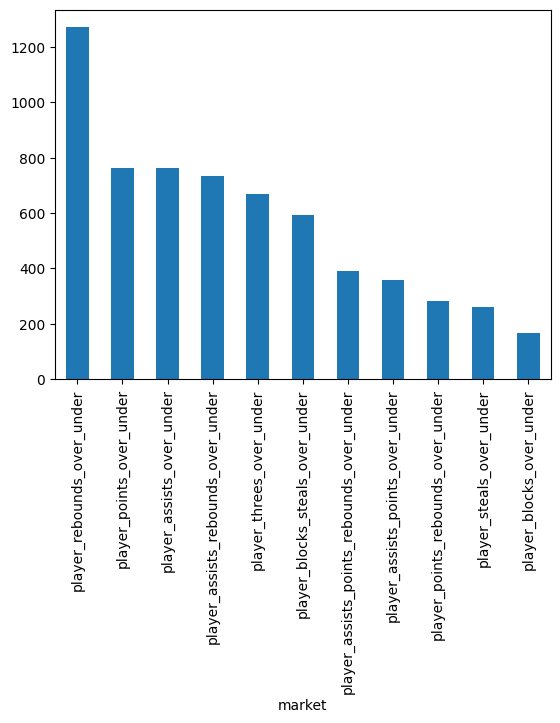

In [ ]:
bets_per_market = bets['market'].value_counts()
print(bets_per_market)

# Graph the bets per market in a bar chart
import matplotlib.pyplot as plt
bets_per_market.plot.bar()
plt.show()

In [ ]:
# We will find the number of potentially fake bets
# We say that a bet is fake if the edge over the house is greater than 10%
fake_bets = bets[bets['ev'] >= 10]
print(fake_bets)

real_bets = bets[bets['ev'] < 10]
print(real_bets)

# Show the size differences between the real and fake bets
print(fake_bets.shape)
print(real_bets.shape)

       participant_name     ev                           market  line   type  \
0           Buddy Hield  16.13         player_threes_over_under   3.5  under   
1          Franz Wagner  16.00         player_threes_over_under   1.5   over   
2         Kawhi Leonard  16.00  player_blocks_steals_over_under   2.5   over   
3        Jordan Hawkins  16.00       player_rebounds_over_under   2.5  under   
4     Jonas Valanciunas  15.30  player_blocks_steals_over_under   1.5  under   
...                 ...    ...                              ...   ...    ...   
6155    Zion Williamson  10.17       player_rebounds_over_under   6.5   over   
6232   D'Angelo Russell  14.13         player_threes_over_under   2.5  under   
6233       Jusuf Nurkic  11.13        player_assists_over_under   2.5   over   
6234       Devin Booker  10.91        player_assists_over_under   6.5  under   
6235       Jamal Murray  10.17         player_threes_over_under   2.5  under   

                                       